In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from datetime import datetime

import statsmodels.api as sm

## prepare the data. 
## the following code was adapted from milestone 1 notebook

def prepare_data():
    df = pd.read_csv(os.path.join('.', 'dataset', 'energey_temperature_data.csv'))
    
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)
    df.columns = ['mw', 'temp', 'hour_of_day', 'day_of_week', 'month', 'year']
    
    train_set = df[:'2019-12-31']
    test_set = df['2019-12-31':]
    
    return train_set, test_set

def preprocess(df):
    df['temp'] = (df['temp'] - np.mean(df['temp']))/np.std(df['temp'])
    df['temp_squared'] = df['temp'] ** 2
    return df

(train, test) = prepare_data()

In [2]:
train.head(10)

,mw,temp,hour_of_day,day_of_week,month,year
DATE,,,,,,
2017-02-01 00:00:00,1419.881,37.0,0,2,2,2017
2017-02-01 01:00:00,1379.505,37.0,1,2,2,2017
2017-02-01 02:00:00,1366.106,36.0,2,2,2,2017
2017-02-01 03:00:00,1364.453,36.0,3,2,2,2017
2017-02-01 04:00:00,1391.265,36.0,4,2,2,2017
2017-02-01 05:00:00,1477.343,36.0,5,2,2,2017
2017-02-01 06:00:00,1585.252,34.0,6,2,2,2017
2017-02-01 07:00:00,1671.412,33.0,7,2,2,2017
2017-02-01 08:00:00,1708.597,34.0,8,2,2,2017


## Let’s build up our linear regression step by step. 

In [5]:
train_df = preprocess(train.copy())
train_df.head(10)

,mw,temp,hour_of_day,day_of_week,month,year,temp_squared
DATE,,,,,,,
2017-02-01 00:00:00,1419.881,-0.871682,0,2,2,2017,0.759830
2017-02-01 01:00:00,1379.505,-0.871682,1,2,2,2017,0.759830
2017-02-01 02:00:00,1366.106,-0.924684,2,2,2,2017,0.855040
2017-02-01 03:00:00,1364.453,-0.924684,3,2,2,2017,0.855040
2017-02-01 04:00:00,1391.265,-0.924684,4,2,2,2017,0.855040
2017-02-01 05:00:00,1477.343,-0.924684,5,2,2,2017,0.855040
2017-02-01 06:00:00,1585.252,-1.030687,6,2,2,2017,1.062315
2017-02-01 07:00:00,1671.412,-1.083688,7,2,2,2017,1.174380
2017-02-01 08:00:00,1708.597,-1.030687,8,2,2,2017,1.062315


In [6]:
X = sm.add_constant(train_df[['temp', 'hour_of_day', 'day_of_week', 'month', 'year']])
Y = train_df['mw']

first_model = sm.OLS(Y, X).fit()
print(f'Adj R-squared: {first_model.rsquared_adj}, SSE: {first_model.ssr}')

Adj R-squared: 0.27059004863978786, SSE: 1530553061.2761388


### adding the quadratic effect of temp

In [7]:
model2 = sm.OLS.from_formula('mw ~ temp_squared + temp + hour_of_day + day_of_week + month + year', data=train_df).fit()
print(f'Adj R-squared: {model2.rsquared_adj}, SSE: {model2.ssr}')

Adj R-squared: 0.6856430430564661, SSE: 659603225.6245109


In [11]:
# note the impact of changing the time values to categorical variables
model3 = sm.OLS.from_formula('mw ~ temp_squared + temp + C(hour_of_day) + C(day_of_week) + C(month)', data=train_df).fit()
print(f'Adj R-squared: {model3.rsquared_adj}, SSE: {model3.ssr}')

Adj R-squared: 0.8199484981035255, SSE: 377262454.3291232


## 3. Plot the scatterplot between energy and temperature (as in the previous section), but only for the months of January and July.

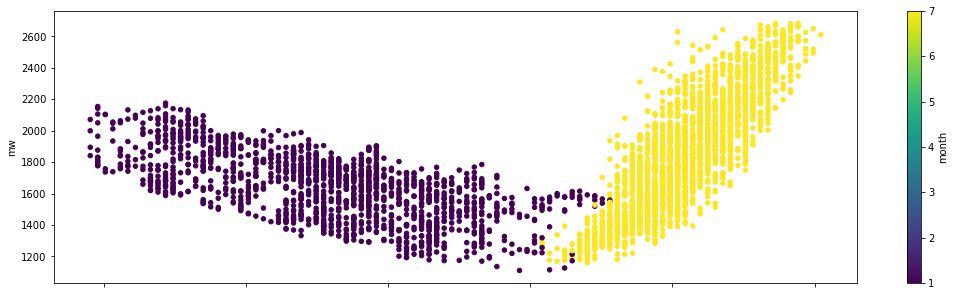

In [14]:
train_df.where((train_df['month'] == 1) | (train_df['month'] == 7)). \
    plot.scatter('temp', 'mw', figsize=(18, 5), c='month', cmap='viridis');

## 4. Plot the scatterplot between energy and temperature (as in the previous section), but only for the hours of midnight and noon.

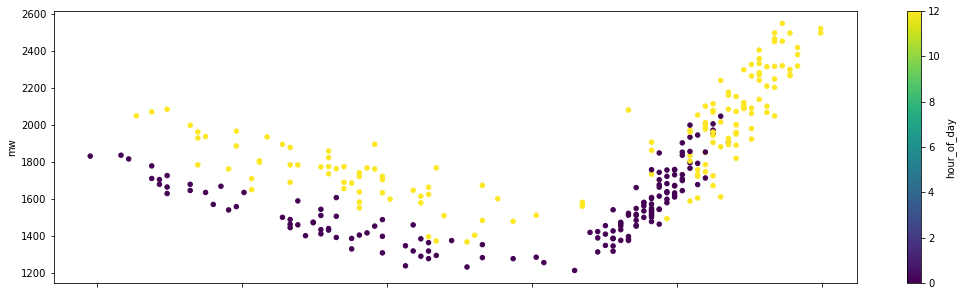

In [15]:
month_condition = (train_df['month'] == 1) | (train_df['month'] == 7)
hourly_condition = (train_df['hour_of_day'] == 0) | (train_df['hour_of_day'] == 12)

train_df.where(month_condition & hourly_condition). \
    plot.scatter('temp', 'mw', figsize=(18, 5), c='hour_of_day', cmap='viridis');

The previous two steps reveal that energy has a different relationship with temperature depending on what time of day and month of year it is. These are called interactions between variables for a linear regression. Without those plots we might have missed that energy has a changing effect with temperature at different times. Add these new interactions to the linear regression model you previously built.
- Remember that an interaction is just the multiplication of two variables. Luckily, using the formula approach of theOLS.from_formula function, we can easily add this into our models. If you wanted to build a linear regression with temperature, day of week, and the interaction between them (telling the model that the effect of temperature changes depending on the day of week), you could do the following: sm.OLS.from_formula('MW ~ Temp + C(day) + Temp*C(day)', data=train).fit().

### Build the linear regression model you built in step 2, but add the interactions of hour of day with both temperature and temperature squared, as well as the interaction of month of year with both temperature and temperature squared.

In [29]:
formula_expr = 'mw ~ temp_squared + C(hour_of_day) + C(day_of_week) + C(month) + temp * C(hour_of_day) + temp_squared * C(hour_of_day) + temp * C(month) + temp_squared * C(month)'
model4 = sm.OLS.from_formula(formula_expr, data=train_df).fit()
print(f'Adj R-squared: {model4.rsquared_adj}, SSE: {model4.ssr}')

Adj R-squared: 0.9013412476890591, SSE: 206168576.27831194


### Previously you also observed that the relationship between energy and hour of day changes depending on what day of the week it is. Add this new interaction to your linear regression model and evaluate your model.

In [50]:
formula_expr2 = 'mw ~ C(hour_of_day) + C(day_of_week) + C(month) + temp * C(hour_of_day) + ' + \
                'temp_squared * C(hour_of_day) + temp * C(month) + temp_squared * C(month) + C(day_of_week) * C(hour_of_day)'
model5 = sm.OLS.from_formula(formula_expr2, data=train_df).fit()
print(f'Adj R-squared: {model5.rsquared_adj}, SSE: {model5.ssr}')

Adj R-squared: 0.913241295196604, SSE: 180316828.38273168


In [37]:
# for comparison
print('Comparing all versions of the model so far ........')
print(f'model 1 ==>> Adj R-squared: {first_model.rsquared_adj}, SSE: {first_model.ssr}, Total MSE: {first_model.mse_total}')
print(f'model 2 ==>> Adj R-squared: {model2.rsquared_adj}, SSE: {model2.ssr}, Total MSE: {model2.mse_total}')
print(f'model 3 ==>> Adj R-squared: {model3.rsquared_adj}, SSE: {model3.ssr}, Total MSE: {model3.mse_total}')
print(f'model 4 ==>> Adj R-squared: {model4.rsquared_adj}, SSE: {model4.ssr}, Total MSE: {model4.mse_total}')
print(f'model 5 ==>> Adj R-squared: {model5.rsquared_adj}, SSE: {model5.ssr}, Total MSE: {model5.mse_total}')

Comparing all versions of the model so far ........
model 1 ==>> Adj R-squared: 0.27059004863978786, SSE: 1530553061.2761388, Total MSE: 82191.30790811659
model 2 ==>> Adj R-squared: 0.6856430430564661, SSE: 659603225.6245109, Total MSE: 82191.30790811659
model 3 ==>> Adj R-squared: 0.8199484981035255, SSE: 377262454.3291232, Total MSE: 82191.30790811659
model 4 ==>> Adj R-squared: 0.9013412476890591, SSE: 206168576.27831194, Total MSE: 82191.30790811659
model 5 ==>> Adj R-squared: 0.913241295196604, SSE: 180316828.38273168, Total MSE: 82191.30790811659


### A good evaluation of a model is mean absolute percentage error (MAPE). This is because we want to evaluate on average how far off our predictions are in terms of percentages. The MAPE is calculated as:

In [38]:
def mean_percentage_error(y, y_hats):
    res_ratio = np.abs(y - y_hats) / y
    return 100 * (np.sum(res_ratio)/len(y))

### Calculate the predictions (or fitted values) from your final linear regression model on your training dataset. Calculate the MAPE for these predictions from your training dataset.

In [39]:
train_predictions = model4.predict(train_df)
mape = mean_percentage_error(Y, train_predictions)
print('Mean percentage errors: ', mape)

Mean percentage errors:  4.14951088065223


## Forecasting on the test set

In [43]:
test2 = preprocess(test)
test_prediction = model5.predict(test2)
test_mape = mean_percentage_error(test2['mw'], test_prediction)
print('Test set mean percentage errors: ', test_mape)

Test set mean percentage errors:  5.21998849713974


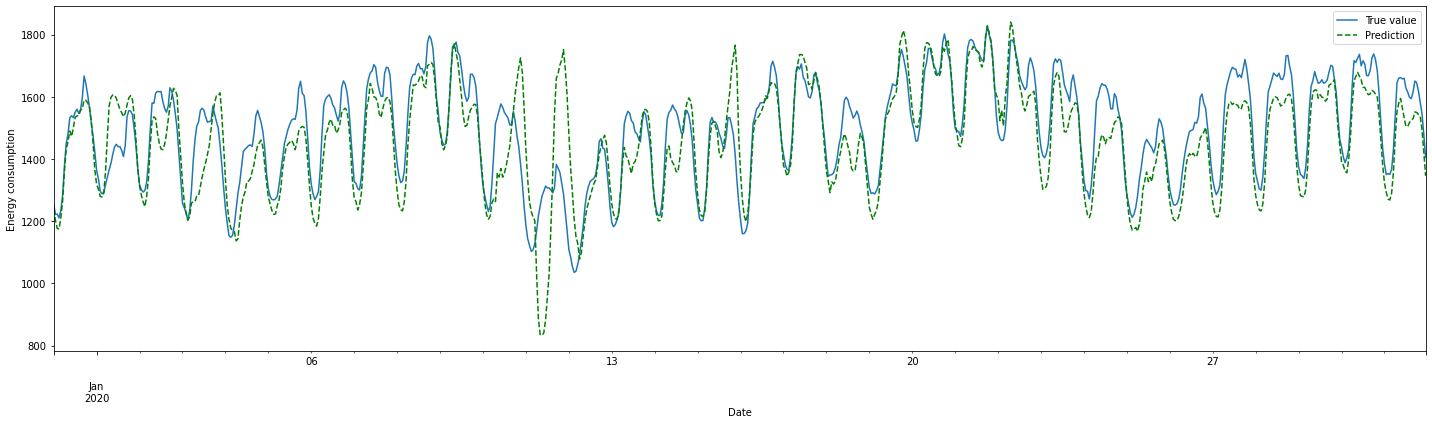

In [44]:
ax1 = test['mw'].plot(figsize=(20, 6), label='True value')
test_prediction.plot(figsize=(20, 6), ax=ax1, label='Prediction', style='g--')
ax1.set_ylabel('Energy consumption')
ax1.set_xlabel('Date')
ax1.legend()

plt.tight_layout()